PyTorch: 2.9.1+cu128
GPU: NVIDIA A100-SXM4-80GB MIG 3g.40gb
Memory: 42.1 GB

Encoder: efficientnet-b3

Training with Pretrained Backbone
Encoder: efficientnet-b3 (pretrained on imagenet)
Resolution: 640x640
LR: 0.0001
  1000 images from ./arcade/syntax/train/images
  200 images from ./arcade/syntax/val/images
  300 images from ./arcade/syntax/test/images
Train: 1080, Val: 120, Test: 300
Total Parameters: 13,715,242
Trainable Parameters: 13,715,242


/tmp/ipykernel_148572/4246860043.py:579: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch   1/150 | Loss: 0.6922/0.6749 | F1: 0.2280 | clDice: 0.2290 | LR: 9.97e-05 ★
Epoch   5/150 | Loss: 0.2718/0.3020 | F1: 0.6682 | clDice: 0.6851 | LR: 9.34e-05 ★
Epoch  10/150 | Loss: 0.2349/0.2473 | F1: 0.7125 | clDice: 0.7439 | LR: 7.52e-05 ★
Epoch  15/150 | Loss: 0.2227/0.2400 | F1: 0.7180 | clDice: 0.7533 | LR: 5.05e-05 ★
Epoch  20/150 | Loss: 0.2172/0.2355 | F1: 0.7222 | clDice: 0.7564 | LR: 2.58e-05 ★
Epoch  25/150 | Loss: 0.2138/0.2364 | F1: 0.7185 | clDice: 0.7563 | LR: 7.63e-06
Epoch  30/150 | Loss: 0.2111/0.2314 | F1: 0.7230 | clDice: 0.7641 | LR: 1.00e-04
Epoch  35/150 | Loss: 0.2049/0.2266 | F1: 0.7287 | clDice: 0.7658 | LR: 9.83e-05 ★
Epoch  40/150 | Loss: 0.1996/0.2179 | F1: 0.7358 | clDice: 0.7781 | LR: 9.34e-05
Epoch  45/150 | Loss: 0.1900/0.2143 | F1: 0.7403 | clDice: 0.7842 | LR: 8.55e-05
Epoch  50/150 | Loss: 0.1815/0.2095 | F1: 0.7471 | clDice: 0.7959 | LR: 7.52e-05
Epoch  55/150 | Loss: 0.1742/0.2011 | F1: 0.7557 | clDice: 0.7996 | LR: 6.33e-05 ★
Epoch  60/150 

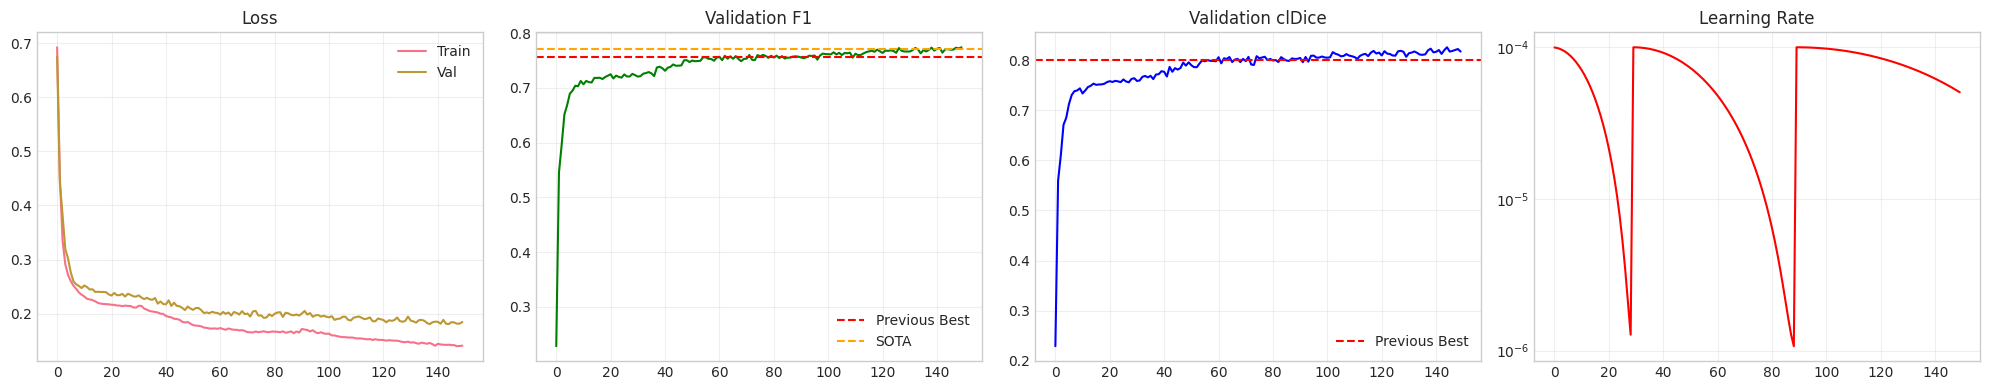


SUMMARY
Encoder: efficientnet-b3

Regular: F1=0.7643, clDice=0.7915
TTA:     F1=0.7728, clDice=0.7833

Previous best: F1=0.7557, clDice=0.8014


In [5]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms.functional as TF
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt
import random
from skimage.morphology import skeletonize

# Pretrained backbones
import segmentation_models_pytorch as smp

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# ============== CONFIG: Same as best run + pretrained backbone ==============
CONFIG = {
    "IMG_SIZE": 640,
    "BATCH_SIZE": 8,
    "EPOCHS": 150,
    "LR": 1e-4,
    "MIN_LR": 1e-6,
    "WEIGHT_DECAY": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    
    "TRAIN_JSON": "./arcade/syntax/train/annotations/train.json",
    "TRAIN_IMG_DIR": "./arcade/syntax/train/images",
    "VAL_JSON": "./arcade/syntax/val/annotations/val.json",
    "VAL_IMG_DIR": "./arcade/syntax/val/images",
    "TEST_JSON": "./arcade/syntax/test/annotations/test.json",
    "TEST_IMG_DIR": "./arcade/syntax/test/images",
    
    "NUM_WORKERS": 4,
    "SEED": 42,
    
    # Same proven loss weights
    "BCE_WEIGHT": 0.2,
    "TVERSKY_WEIGHT": 0.45,
    "TVERSKY_ALPHA": 0.4,
    "TVERSKY_BETA": 0.6,
    "CLDICE_WEIGHT": 0.35,
    
    # Backbone options (uncomment one):
    # "ENCODER": "resnet34",      # ~24M params, good balance
    "ENCODER": "efficientnet-b3",  # ~12M params, efficient
    # "ENCODER": "resnet50",      # ~32M params, more capacity
    # "ENCODER": "efficientnet-b4", # ~19M params
    
    "ENCODER_WEIGHTS": "imagenet",
    "DROPOUT": 0.1,
    "TTA_VIEWS": 6,
    
    "CHECKPOINT_DIR": "./checkpoints_pretrained"
}


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])


# ============== CHECKPOINT ==============
def save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_score, history, filepath):
    checkpoint = {
        'epoch': int(epoch),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'scaler_state_dict': scaler.state_dict() if scaler else None,
        'best_score': float(best_score),
        'history': {k: [float(v) for v in vals] for k, vals in history.items()},
    }
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    torch.save(checkpoint, filepath)


def load_checkpoint(filepath, model, optimizer=None, scheduler=None, scaler=None, device='cuda'):
    if not os.path.exists(filepath):
        return 0, 0.0, {}
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint.get('scheduler_state_dict'):
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler and checkpoint.get('scaler_state_dict'):
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Loaded: {filepath} (Epoch {checkpoint.get('epoch', 0)}, Best: {checkpoint.get('best_score', 0):.4f})")
    return checkpoint.get('epoch', 0), checkpoint.get('best_score', 0.0), checkpoint.get('history', {})


# ============== AUGMENTATION: Same as before ==============
class Augmenter:
    def __init__(self, img_size, p=0.5):
        self.p = p
        self.img_size = img_size
    
    def __call__(self, image, mask):
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        if random.random() < self.p:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        if random.random() < self.p:
            angle = random.uniform(-45, 45)
            image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
        
        if random.random() < self.p:
            scale = random.uniform(0.8, 1.2)
            new_size = int(self.img_size * scale)
            image = TF.resize(image, [new_size, new_size], interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.resize(mask, [new_size, new_size], interpolation=TF.InterpolationMode.NEAREST)
            
            if scale > 1:
                image = TF.center_crop(image, [self.img_size, self.img_size])
                mask = TF.center_crop(mask, [self.img_size, self.img_size])
            else:
                pad = (self.img_size - new_size) // 2
                pad_extra = self.img_size - new_size - 2 * pad
                image = TF.pad(image, [pad, pad, pad + pad_extra, pad + pad_extra])
                mask = TF.pad(mask, [pad, pad, pad + pad_extra, pad + pad_extra])
        
        if random.random() < self.p:
            image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        if random.random() < self.p:
            image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
        
        if random.random() < self.p * 0.5:
            noise = torch.randn_like(image) * 0.03
            image = torch.clamp(image + noise, 0, 1)
        
        if random.random() < self.p * 0.5:
            gamma = random.uniform(0.8, 1.2)
            image = torch.pow(image.clamp(min=1e-8), gamma)
        
        return image, mask


# ============== DATASET: Now outputs 3-channel for pretrained backbone ==============
class ArcadeDataset(Dataset):
    def __init__(self, images_dir, json_file, img_size=640, augment=False):
        self.images_dir = images_dir
        self.img_size = img_size
        self.augment = augment
        self.augmenter = Augmenter(img_size, p=0.5) if augment else None
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
        with open(json_file, 'r') as f:
            self.coco_data = json.load(f)

        self.img_id_to_ann = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_ann:
                self.img_id_to_ann[img_id] = []
            self.img_id_to_ann[img_id].append(ann)
            
        self.images_info = [img for img in self.coco_data['images'] 
                          if os.path.exists(os.path.join(images_dir, img['file_name']))]
        print(f"  {len(self.images_info)} images from {images_dir}")

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            image = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        else:
            image = self.clahe.apply(image)
            
        h, w = image.shape
        mask = np.zeros((h, w), dtype=np.uint8)
        
        for ann in self.img_id_to_ann.get(img_info['id'], []):
            if 'segmentation' in ann:
                for poly in ann['segmentation']:
                    if len(poly) >= 6:
                        poly_arr = np.array(poly).reshape((-1, 2)).astype(np.int32)
                        cv2.fillPoly(mask, [poly_arr], 1)

        # Single channel for augmentation
        image_t = torch.from_numpy(image).float().unsqueeze(0) / 255.0
        mask_t = torch.from_numpy(mask).float().unsqueeze(0)
        
        image_t = TF.resize(image_t, [self.img_size, self.img_size], 
                           interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        mask_t = TF.resize(mask_t, [self.img_size, self.img_size], 
                          interpolation=TF.InterpolationMode.NEAREST)

        if self.augment and self.augmenter:
            image_t, mask_t = self.augmenter(image_t, mask_t)
        
        # Convert to 3 channels for pretrained backbone (repeat grayscale)
        image_t = image_t.repeat(3, 1, 1)

        return image_t, mask_t, img_info['file_name']


# ============== LOSSES: Same proven losses ==============
def soft_erode(img, kernel_size=3):
    return -F.max_pool2d(-img, kernel_size, stride=1, padding=kernel_size // 2)

def soft_dilate(img, kernel_size=3):
    return F.max_pool2d(img, kernel_size, stride=1, padding=kernel_size // 2)

def soft_open(img, kernel_size=3):
    return soft_dilate(soft_erode(img, kernel_size), kernel_size)

def soft_skeleton(img, num_iter=10):
    skeleton = torch.zeros_like(img)
    for _ in range(num_iter):
        img_eroded = soft_erode(img)
        delta = torch.clamp(img - soft_open(img), min=0)
        skeleton = torch.clamp(skeleton + delta, max=1)
        img = img_eroded
    return skeleton


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.4, beta=0.6, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred_flat = pred.contiguous().view(-1)
        target_flat = target.contiguous().view(-1)
        
        tp = (pred_flat * target_flat).sum()
        fp = (pred_flat * (1 - target_flat)).sum()
        fn = ((1 - pred_flat) * target_flat).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky


class clDiceLoss(nn.Module):
    def __init__(self, smooth=1.0, num_iter=10):
        super().__init__()
        self.smooth = smooth
        self.num_iter = num_iter
    
    def forward(self, pred, target):
        pred_skel = soft_skeleton(pred, self.num_iter)
        target_skel = soft_skeleton(target, self.num_iter)
        
        tprec = ((pred_skel * target).sum() + self.smooth) / (pred_skel.sum() + self.smooth)
        tsens = ((target_skel * pred).sum() + self.smooth) / (target_skel.sum() + self.smooth)
        
        cl_dice = 2.0 * (tprec * tsens) / (tprec + tsens + 1e-7)
        return 1.0 - cl_dice


class CombinedLoss(nn.Module):
    def __init__(self, bce_w=0.2, tversky_w=0.45, cldice_w=0.35,
                 tversky_alpha=0.4, tversky_beta=0.6):
        super().__init__()
        self.bce_w = bce_w
        self.tversky_w = tversky_w
        self.cldice_w = cldice_w
        
        self.bce = nn.BCEWithLogitsLoss()
        self.tversky = TverskyLoss(alpha=tversky_alpha, beta=tversky_beta)
        self.cldice = clDiceLoss()
    
    def forward(self, pred, target):
        pred_sig = torch.sigmoid(pred)
        
        loss_bce = self.bce(pred, target)
        loss_tversky = self.tversky(pred_sig, target)
        loss_cldice = self.cldice(pred_sig, target)
        
        total = (self.bce_w * loss_bce + 
                 self.tversky_w * loss_tversky + 
                 self.cldice_w * loss_cldice)
        
        return total, {
            'bce': loss_bce.item(),
            'tversky': loss_tversky.item(),
            'cldice': loss_cldice.item()
        }


# ============== MODEL: Pretrained Backbone ==============
def create_model(config):
    """
    Create model with pretrained encoder.
    
    Options in segmentation_models_pytorch:
    - UNet: Standard U-Net
    - UnetPlusPlus: U-Net++ with nested skip connections
    - MAnet: Multi-scale Attention Net
    - FPN: Feature Pyramid Network
    - DeepLabV3Plus: DeepLab v3+
    """
    
    model = smp.UnetPlusPlus(
        encoder_name=config['ENCODER'],
        encoder_weights=config['ENCODER_WEIGHTS'],
        in_channels=3,  # Pretrained expects 3 channels
        classes=1,
        activation=None,  # We apply sigmoid in loss
        decoder_attention_type='scse',  # Spatial + Channel SE attention
    )
    
    return model


# Alternative models to try:
def create_model_variants(config, variant='unetpp'):
    """Different architecture options"""
    
    if variant == 'unet':
        return smp.Unet(
            encoder_name=config['ENCODER'],
            encoder_weights=config['ENCODER_WEIGHTS'],
            in_channels=3,
            classes=1,
            activation=None,
        )
    
    elif variant == 'unetpp':
        return smp.UnetPlusPlus(
            encoder_name=config['ENCODER'],
            encoder_weights=config['ENCODER_WEIGHTS'],
            in_channels=3,
            classes=1,
            activation=None,
            decoder_attention_type='scse',
        )
    
    elif variant == 'manet':
        return smp.MAnet(
            encoder_name=config['ENCODER'],
            encoder_weights=config['ENCODER_WEIGHTS'],
            in_channels=3,
            classes=1,
            activation=None,
        )
    
    elif variant == 'deeplabv3p':
        return smp.DeepLabV3Plus(
            encoder_name=config['ENCODER'],
            encoder_weights=config['ENCODER_WEIGHTS'],
            in_channels=3,
            classes=1,
            activation=None,
        )
    
    else:
        raise ValueError(f"Unknown variant: {variant}")


# ============== TTA ==============
def predict_with_tta(model, images, device, num_views=6):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        preds = []
        
        preds.append(torch.sigmoid(model(images)))
        
        p = torch.sigmoid(model(TF.hflip(images)))
        preds.append(TF.hflip(p))
        
        p = torch.sigmoid(model(TF.vflip(images)))
        preds.append(TF.vflip(p))
        
        p = torch.sigmoid(model(TF.vflip(TF.hflip(images))))
        preds.append(TF.hflip(TF.vflip(p)))
        
        p = torch.sigmoid(model(torch.rot90(images, 1, [2, 3])))
        preds.append(torch.rot90(p, -1, [2, 3]))
        
        p = torch.sigmoid(model(torch.rot90(images, 3, [2, 3])))
        preds.append(torch.rot90(p, -3, [2, 3]))
        
        return torch.stack(preds[:num_views]).mean(dim=0)


# ============== METRICS ==============
def compute_cldice(pred_binary, target_binary):
    pred_np = pred_binary.cpu().numpy().squeeze().astype(np.uint8)
    target_np = target_binary.cpu().numpy().squeeze().astype(np.uint8)
    
    if pred_np.sum() == 0 and target_np.sum() == 0:
        return 1.0
    if pred_np.sum() == 0 or target_np.sum() == 0:
        return 0.0
    
    try:
        pred_skel = skeletonize(pred_np).astype(np.float32)
        target_skel = skeletonize(target_np).astype(np.float32)
    except:
        return 0.0
    
    if pred_skel.sum() == 0 or target_skel.sum() == 0:
        return 0.0
    
    tprec = (pred_skel * target_np).sum() / (pred_skel.sum() + 1e-7)
    tsens = (target_skel * pred_np).sum() / (target_skel.sum() + 1e-7)
    
    return float(2.0 * tprec * tsens / (tprec + tsens + 1e-7))


def compute_metrics(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    tp = (pred_flat * target_flat).sum()
    fp = (pred_flat * (1 - target_flat)).sum()
    fn = ((1 - pred_flat) * target_flat).sum()
    
    precision = (tp + 1e-7) / (tp + fp + 1e-7)
    recall = (tp + 1e-7) / (tp + fn + 1e-7)
    f1 = (2 * precision * recall) / (precision + recall + 1e-7)
    dice = (2 * tp + 1e-7) / (2 * tp + fp + fn + 1e-7)
    iou = (tp + 1e-7) / (tp + fp + fn + 1e-7)
    
    cldice = compute_cldice(pred_binary, target)
    
    return {
        'f1': f1.item(),
        'dice': dice.item(),
        'cldice': cldice,
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item(),
    }


def find_optimal_threshold(model, data_loader, device, use_tta=False):
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for images, masks, _ in data_loader:
            if use_tta:
                preds = predict_with_tta(model, images, device).cpu()
            else:
                preds = torch.sigmoid(model(images.to(device))).cpu()
            all_preds.append(preds)
            all_targets.append(masks)
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    best_f1, best_thresh = 0, 0.5
    
    print("\nThreshold search:")
    for thresh in np.arange(0.30, 0.60, 0.05):
        pred_bin = (all_preds > thresh).float()
        
        tp = (pred_bin.view(-1) * all_targets.view(-1)).sum()
        fp = (pred_bin.view(-1) * (1 - all_targets.view(-1))).sum()
        fn = ((1 - pred_bin.view(-1)) * all_targets.view(-1)).sum()
        
        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        f1 = 2 * precision * recall / (precision + recall + 1e-7)
        
        print(f"  {thresh:.2f}: F1={f1:.4f}, P={precision:.4f}, R={recall:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    print(f"Optimal: {best_thresh:.2f} (F1={best_f1:.4f})")
    return best_thresh


def evaluate(model, data_loader, device, name, threshold=0.5, use_tta=False):
    model.eval()
    all_metrics = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {name} ({'TTA' if use_tta else 'Regular'}, thresh={threshold:.2f})")
    print(f"{'='*60}")
    
    with torch.no_grad():
        for images, masks, _ in data_loader:
            if use_tta:
                preds = predict_with_tta(model, images, device)
            else:
                preds = torch.sigmoid(model(images.to(device)))
            
            masks = masks.to(device)
            for pred, mask in zip(preds, masks):
                all_metrics.append(compute_metrics(pred.unsqueeze(0), mask.unsqueeze(0), threshold))
    
    avg = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    std = {k: np.std([m[k] for m in all_metrics]) for k in all_metrics[0]}
    
    print(f"\nResults ({len(all_metrics)} samples):")
    for k in ['f1', 'dice', 'cldice', 'precision', 'recall']:
        print(f"  {k.upper():<10}: {avg[k]:.4f} ± {std[k]:.4f}")
    
    return avg, std


# ============== TRAINING ==============
def train(config, resume_from=None):
    device = config['DEVICE']
    
    print(f"\n{'='*60}")
    print("Training with Pretrained Backbone")
    print(f"{'='*60}")
    print(f"Encoder: {config['ENCODER']} (pretrained on {config['ENCODER_WEIGHTS']})")
    print(f"Resolution: {config['IMG_SIZE']}x{config['IMG_SIZE']}")
    print(f"LR: {config['LR']}")
    
    os.makedirs(config['CHECKPOINT_DIR'], exist_ok=True)
    
    # Data
    train_dataset = ArcadeDataset(config['TRAIN_IMG_DIR'], config['TRAIN_JSON'], 
                                  config['IMG_SIZE'], augment=True)
    val_aug = ArcadeDataset(config['VAL_IMG_DIR'], config['VAL_JSON'], 
                            config['IMG_SIZE'], augment=True)
    test_dataset = ArcadeDataset(config['TEST_IMG_DIR'], config['TEST_JSON'], 
                                 config['IMG_SIZE'], augment=False)
    
    combined = ConcatDataset([train_dataset, val_aug])
    n_val = int(len(combined) * 0.1)
    indices = list(range(len(combined)))
    np.random.shuffle(indices)
    
    train_subset = torch.utils.data.Subset(combined, indices[:-n_val])
    val_subset = torch.utils.data.Subset(combined, indices[-n_val:])
    
    print(f"Train: {len(train_subset)}, Val: {len(val_subset)}, Test: {len(test_dataset)}")
    
    train_loader = DataLoader(train_subset, batch_size=config['BATCH_SIZE'], shuffle=True,
                             num_workers=config['NUM_WORKERS'], pin_memory=True, 
                             persistent_workers=True, drop_last=True)
    val_loader = DataLoader(val_subset, batch_size=config['BATCH_SIZE'], shuffle=False,
                           num_workers=config['NUM_WORKERS'], pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False,
                            num_workers=config['NUM_WORKERS'], pin_memory=True, persistent_workers=True)
    
    # Model with pretrained backbone
    model = create_model(config).to(device)
    
    num_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {num_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    # Different LR for encoder (pretrained) vs decoder (random)
    encoder_params = list(model.encoder.parameters())
    decoder_params = [p for n, p in model.named_parameters() if 'encoder' not in n]
    
    optimizer = optim.AdamW([
        {'params': encoder_params, 'lr': config['LR'] * 0.1},  # Lower LR for pretrained
        {'params': decoder_params, 'lr': config['LR']}
    ], weight_decay=config['WEIGHT_DECAY'])
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2, eta_min=config['MIN_LR'])
    scaler = GradScaler()
    
    loss_fn = CombinedLoss(
        bce_w=config['BCE_WEIGHT'],
        tversky_w=config['TVERSKY_WEIGHT'],
        cldice_w=config['CLDICE_WEIGHT'],
        tversky_alpha=config['TVERSKY_ALPHA'],
        tversky_beta=config['TVERSKY_BETA']
    )
    
    start_epoch, best_f1 = 0, 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_cldice': [], 'lr': []}
    
    if resume_from and os.path.exists(resume_from):
        start_epoch, best_f1, history = load_checkpoint(resume_from, model, optimizer, scheduler, scaler, device)
        start_epoch += 1
    
    patience, patience_counter = 30, 0
    best_state = None
    
    for epoch in range(start_epoch, config['EPOCHS']):
        model.train()
        train_losses = []
        
        for images, masks, _ in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss, _ = loss_fn(outputs, masks)
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            train_losses.append(loss.item())
        
        scheduler.step()
        
        # Validate
        model.eval()
        val_losses, val_f1s, val_cldices = [], [], []
        
        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss, _ = loss_fn(outputs, masks)
                val_losses.append(loss.item())
                
                preds = torch.sigmoid(outputs)
                for pred, mask in zip(preds, masks):
                    m = compute_metrics(pred.unsqueeze(0), mask.unsqueeze(0))
                    val_f1s.append(m['f1'])
                    val_cldices.append(m['cldice'])
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        avg_val_f1 = np.mean(val_f1s)
        avg_val_cldice = np.mean(val_cldices)
        current_lr = optimizer.param_groups[1]['lr']  # Decoder LR
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(avg_val_f1)
        history['val_cldice'].append(avg_val_cldice)
        history['lr'].append(current_lr)
        
        if avg_val_f1 > best_f1:
            best_f1 = avg_val_f1
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            save_checkpoint(model, optimizer, scheduler, scaler, epoch, best_f1, history,
                          os.path.join(config['CHECKPOINT_DIR'], 'best_model.pth'))
            torch.save(model.state_dict(), os.path.join(config['CHECKPOINT_DIR'], 'best_weights.pth'))
            marker = " ★"
        else:
            patience_counter += 1
            marker = ""
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{config['EPOCHS']} | "
                  f"Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
                  f"F1: {avg_val_f1:.4f} | clDice: {avg_val_cldice:.4f} | "
                  f"LR: {current_lr:.2e}{marker}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    if best_state:
        model.load_state_dict(best_state)
    
    print(f"\nBest F1: {best_f1:.4f}")
    return model, test_loader, val_loader, history


# ============== VISUALIZATION ==============
def plot_history(history, save_path='history_pretrained.png'):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history['val_f1'], color='green')
    axes[1].set_title('Validation F1')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.7557, color='r', linestyle='--', label='Previous Best')
    axes[1].axhline(y=0.77, color='orange', linestyle='--', label='SOTA')
    axes[1].legend()
    
    axes[2].plot(history['val_cldice'], color='blue')
    axes[2].set_title('Validation clDice')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0.8014, color='r', linestyle='--', label='Previous Best')
    axes[2].legend()
    
    axes[3].plot(history['lr'], color='red')
    axes[3].set_title('Learning Rate')
    axes[3].set_yscale('log')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    print(f"Saved: {save_path}")
    plt.show()


# ============== MAIN ==============
if __name__ == "__main__":
    print(f"PyTorch: {torch.__version__}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    print(f"\nEncoder: {CONFIG['ENCODER']}")
    
    # Train
    model, test_loader, val_loader, history = train(CONFIG)
    
    # Find optimal thresholds
    print("\n" + "="*60)
    print("Finding Optimal Thresholds")
    print("="*60)
    
    thresh_reg = find_optimal_threshold(model, test_loader, CONFIG['DEVICE'], use_tta=False)
    thresh_tta = find_optimal_threshold(model, test_loader, CONFIG['DEVICE'], use_tta=True)
    
    # Evaluate
    print("\n" + "="*60)
    print("Final Evaluation")
    print("="*60)
    
    metrics_reg, _ = evaluate(model, test_loader, CONFIG['DEVICE'], "Test (Regular)", thresh_reg, use_tta=False)
    metrics_tta, _ = evaluate(model, test_loader, CONFIG['DEVICE'], "Test (TTA)", thresh_tta, use_tta=True)
    
    # Plot
    plot_history(history)
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Encoder: {CONFIG['ENCODER']}")
    print(f"\nRegular: F1={metrics_reg['f1']:.4f}, clDice={metrics_reg['cldice']:.4f}")
    print(f"TTA:     F1={metrics_tta['f1']:.4f}, clDice={metrics_tta['cldice']:.4f}")
    print(f"\nPrevious best: F1=0.7557, clDice=0.8014")


In [4]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm
from skimage.morphology import skeletonize
import segmentation_models_pytorch as smp
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

torch.backends.cudnn.benchmark = True

# ============== CONFIG ==============
CONFIG = {
    "IMG_SIZE": 640,
    "BATCH_SIZE": 1,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    
    "TEST_JSON": "./arcade/syntax/test/annotations/test.json",
    "TEST_IMG_DIR": "./arcade/syntax/test/images",
    
    "CHECKPOINT": "./checkpoints_pretrained/best_weights.pth",
    "ENCODER": "efficientnet-b3",
    
    "THRESHOLD": 0.45,
    "TTA_VIEWS": 6,
    
    "OUTPUT_DIR": "./final_evaluation",
}

os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)


# ============== DATASET ==============
class ArcadeDataset(Dataset):
    def __init__(self, images_dir, json_file, img_size=640):
        self.images_dir = images_dir
        self.img_size = img_size
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
        with open(json_file, 'r') as f:
            self.coco_data = json.load(f)

        self.img_id_to_ann = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_ann:
                self.img_id_to_ann[img_id] = []
            self.img_id_to_ann[img_id].append(ann)
            
        self.images_info = [img for img in self.coco_data['images'] 
                          if os.path.exists(os.path.join(images_dir, img['file_name']))]
        print(f"Loaded {len(self.images_info)} test images")

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            image = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        else:
            image = self.clahe.apply(image)
            
        h, w = image.shape
        mask = np.zeros((h, w), dtype=np.uint8)
        
        for ann in self.img_id_to_ann.get(img_info['id'], []):
            if 'segmentation' in ann:
                for poly in ann['segmentation']:
                    if len(poly) >= 6:
                        poly_arr = np.array(poly).reshape((-1, 2)).astype(np.int32)
                        cv2.fillPoly(mask, [poly_arr], 1)

        image_t = torch.from_numpy(image).float().unsqueeze(0) / 255.0
        mask_t = torch.from_numpy(mask).float().unsqueeze(0)
        
        image_t = TF.resize(image_t, [self.img_size, self.img_size], 
                           interpolation=TF.InterpolationMode.BILINEAR, antialias=True)
        mask_t = TF.resize(mask_t, [self.img_size, self.img_size], 
                          interpolation=TF.InterpolationMode.NEAREST)
        
        image_t = image_t.repeat(3, 1, 1)

        return image_t, mask_t, img_info['file_name']


# ============== MODEL ==============
def load_model(config):
    model = smp.UnetPlusPlus(
        encoder_name=config['ENCODER'],
        encoder_weights=None,
        in_channels=3,
        classes=1,
        activation=None,
        decoder_attention_type='scse',
    )
    
    state_dict = torch.load(config['CHECKPOINT'], map_location=config['DEVICE'], weights_only=True)
    model.load_state_dict(state_dict)
    model = model.to(config['DEVICE'])
    model.eval()
    
    print(f"Model loaded from {config['CHECKPOINT']}")
    return model


# ============== TTA ==============
def predict_with_tta(model, images, device, num_views=6):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        preds = []
        
        preds.append(torch.sigmoid(model(images)))
        
        p = torch.sigmoid(model(TF.hflip(images)))
        preds.append(TF.hflip(p))
        
        p = torch.sigmoid(model(TF.vflip(images)))
        preds.append(TF.vflip(p))
        
        p = torch.sigmoid(model(TF.vflip(TF.hflip(images))))
        preds.append(TF.hflip(TF.vflip(p)))
        
        p = torch.sigmoid(model(torch.rot90(images, 1, [2, 3])))
        preds.append(torch.rot90(p, -1, [2, 3]))
        
        p = torch.sigmoid(model(torch.rot90(images, 3, [2, 3])))
        preds.append(torch.rot90(p, -3, [2, 3]))
        
        return torch.stack(preds[:num_views]).mean(dim=0)


# ============== METRICS ==============
def compute_cldice(pred_binary, target_binary):
    pred_np = pred_binary.cpu().numpy().squeeze().astype(np.uint8)
    target_np = target_binary.cpu().numpy().squeeze().astype(np.uint8)
    
    if pred_np.sum() == 0 and target_np.sum() == 0:
        return 1.0
    if pred_np.sum() == 0 or target_np.sum() == 0:
        return 0.0
    
    try:
        pred_skel = skeletonize(pred_np).astype(np.float32)
        target_skel = skeletonize(target_np).astype(np.float32)
    except:
        return 0.0
    
    if pred_skel.sum() == 0 or target_skel.sum() == 0:
        return 0.0
    
    tprec = (pred_skel * target_np).sum() / (pred_skel.sum() + 1e-7)
    tsens = (target_skel * pred_np).sum() / (target_skel.sum() + 1e-7)
    
    return float(2.0 * tprec * tsens / (tprec + tsens + 1e-7))


def compute_metrics(pred, target, threshold=0.5):
    pred_binary = (pred > threshold).float()
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    tp = (pred_flat * target_flat).sum()
    fp = (pred_flat * (1 - target_flat)).sum()
    fn = ((1 - pred_flat) * target_flat).sum()
    tn = ((1 - pred_flat) * (1 - target_flat)).sum()
    
    precision = (tp + 1e-7) / (tp + fp + 1e-7)
    recall = (tp + 1e-7) / (tp + fn + 1e-7)
    f1 = (2 * precision * recall) / (precision + recall + 1e-7)
    dice = (2 * tp + 1e-7) / (2 * tp + fp + fn + 1e-7)
    iou = (tp + 1e-7) / (tp + fp + fn + 1e-7)
    specificity = (tn + 1e-7) / (tn + fp + 1e-7)
    
    cldice = compute_cldice(pred_binary, target)
    
    gt_area = target_flat.sum().item()
    pred_area = pred_flat.sum().item()
    area_ratio = pred_area / (gt_area + 1e-7)
    
    return {
        'f1': f1.item(),
        'dice': dice.item(),
        'cldice': cldice,
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'specificity': specificity.item(),
        'tp': tp.item(),
        'fp': fp.item(),
        'fn': fn.item(),
        'tn': tn.item(),
        'gt_area': gt_area,
        'pred_area': pred_area,
        'area_ratio': area_ratio,
    }


# ============== INFERENCE ==============
def run_full_evaluation(model, dataset, config):
    device = config['DEVICE']
    threshold = config['THRESHOLD']
    
    all_results = []
    all_predictions = {}
    
    print(f"\n{'='*70}")
    print(f"Running inference on {len(dataset)} test samples")
    print(f"Threshold: {threshold}, TTA Views: {config['TTA_VIEWS']}")
    print(f"{'='*70}\n")
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    
    with torch.no_grad():
        for idx, (image, mask, filename) in enumerate(tqdm(dataloader, desc="Evaluating")):
            pred = predict_with_tta(model, image, device, config['TTA_VIEWS'])
            
            pred = pred.cpu().squeeze()
            mask = mask.cpu().squeeze()
            image = image.cpu().squeeze()
            
            metrics = compute_metrics(pred.unsqueeze(0), mask.unsqueeze(0), threshold)
            metrics['filename'] = filename[0]
            metrics['index'] = idx
            
            all_results.append(metrics)
            
            all_predictions[filename[0]] = {
                'image': image[0].numpy(),
                'mask': mask.numpy(),
                'pred_prob': pred.numpy(),
                'pred_binary': (pred.numpy() > threshold).astype(np.uint8),
            }
            
            if idx % 50 == 0:
                torch.cuda.empty_cache()
    
    df = pd.DataFrame(all_results)
    return df, all_predictions


# ============== ANALYSIS ==============
def analyze_results(df, config):
    """Comprehensive analysis of results"""
    
    print("\n" + "="*70)
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print("="*70)
    
    print("\n" + "-"*50)
    print("OVERALL STATISTICS")
    print("-"*50)
    
    for metric in ['f1', 'dice', 'cldice', 'iou', 'precision', 'recall']:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        min_val = df[metric].min()
        max_val = df[metric].max()
        median_val = df[metric].median()
        
        print(f"{metric.upper():<12}: {mean_val:.4f} ± {std_val:.4f}  "
              f"[Min: {min_val:.4f}, Max: {max_val:.4f}, Median: {median_val:.4f}]")
    
    print("\n" + "-"*50)
    print("F1 SCORE DISTRIBUTION")
    print("-"*50)
    
    bins = [(0.0, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
    for low, high in bins:
        count = ((df['f1'] >= low) & (df['f1'] < high)).sum()
        pct = count / len(df) * 100
        bar = '█' * int(pct / 2)
        print(f"  {low:.1f}-{high:.1f}: {count:3d} ({pct:5.1f}%) {bar}")
    
    print("\n" + "-"*50)
    print("TOP 10 BEST SAMPLES")
    print("-"*50)
    
    best = df.nlargest(10, 'f1')[['filename', 'f1', 'cldice', 'precision', 'recall']]
    for _, row in best.iterrows():
        print(f"  {row['filename']:<30} F1={row['f1']:.4f} clDice={row['cldice']:.4f}")
    
    print("\n" + "-"*50)
    print("TOP 10 WORST SAMPLES")
    print("-"*50)
    
    worst = df.nsmallest(10, 'f1')[['filename', 'f1', 'cldice', 'precision', 'recall']]
    for _, row in worst.iterrows():
        print(f"  {row['filename']:<30} F1={row['f1']:.4f} clDice={row['cldice']:.4f}")
    
    print("\n" + "-"*50)
    print("FAILURE ANALYSIS")
    print("-"*50)
    
    low_precision = (df['precision'] < 0.6).sum()
    low_recall = (df['recall'] < 0.6).sum()
    low_f1 = (df['f1'] < 0.6).sum()
    
    print(f"  Samples with Precision < 0.6: {low_precision} ({low_precision/len(df)*100:.1f}%)")
    print(f"  Samples with Recall < 0.6:    {low_recall} ({low_recall/len(df)*100:.1f}%)")
    print(f"  Samples with F1 < 0.6:        {low_f1} ({low_f1/len(df)*100:.1f}%)")
    
    csv_path = os.path.join(config['OUTPUT_DIR'], 'all_results.csv')
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to {csv_path}")
    
    return df


# ============== CREATIVE VISUALIZATIONS ==============
def create_radar_chart(df, config):
    """Radar chart of all metrics"""
    
    metrics = ['f1', 'dice', 'cldice', 'iou', 'precision', 'recall']
    values = [df[m].mean() for m in metrics]
    
    N = len(metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    values += values[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    ax.plot(angles, values, 'o-', linewidth=2, color='#2E86AB', markersize=8)
    ax.fill(angles, values, alpha=0.25, color='#2E86AB')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.upper() for m in metrics], fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9, color='gray')
    ax.set_title('Model Performance Radar', fontsize=14, fontweight='bold', pad=20)
    
    for angle, value, metric in zip(angles[:-1], values[:-1], metrics):
        ax.annotate(f'{value:.3f}', xy=(angle, value), xytext=(angle, value + 0.08),
                   ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'radar_chart.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Radar chart saved to {save_path}")
    plt.show()


def create_correlation_heatmap(df, config):
    """Correlation heatmap between all metrics"""
    
    metrics = ['f1', 'cldice', 'iou', 'precision', 'recall', 'gt_area', 'pred_area', 'area_ratio']
    corr_matrix = df[metrics].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap=cmap,
                center=0, square=True, linewidths=0.5, ax=ax,
                cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
                annot_kws={'size': 10})
    
    ax.set_title('Metric Correlation Heatmap', fontsize=14, fontweight='bold', pad=15)
    labels = [m.upper().replace('_', '\n') for m in metrics]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'correlation_heatmap.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Correlation heatmap saved to {save_path}")
    plt.show()


def create_violin_plots(df, config):
    """Violin plots for metric distributions"""
    
    metrics = ['f1', 'cldice', 'precision', 'recall', 'iou']
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
    
    for ax, metric, color in zip(axes, metrics, colors):
        parts = ax.violinplot([df[metric].values], positions=[0], showmeans=True, showmedians=True)
        
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
        
        parts['cmeans'].set_color('black')
        parts['cmedians'].set_color('white')
        parts['cmeans'].set_linewidth(2)
        parts['cmedians'].set_linewidth(2)
        
        x = np.random.normal(0, 0.04, size=len(df))
        ax.scatter(x, df[metric], alpha=0.3, s=10, color=color)
        
        ax.set_title(f'{metric.upper()}\n{df[metric].mean():.4f} ± {df[metric].std():.4f}', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('Score')
        ax.set_xticks([])
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
        
        q1, q2, q3 = df[metric].quantile([0.25, 0.5, 0.75])
        ax.axhline(q1, color='gray', linestyle=':', alpha=0.5, linewidth=1)
        ax.axhline(q2, color='gray', linestyle='-', alpha=0.5, linewidth=1)
        ax.axhline(q3, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    
    plt.suptitle('Metric Distributions (Violin Plots)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = os.path.join(config['OUTPUT_DIR'], 'violin_plots.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Violin plots saved to {save_path}")
    plt.show()


def create_error_analysis_plot(df, config):
    """Analyze where errors come from: FP vs FN dominated"""
    
    df = df.copy()
    df['error_type'] = 'balanced'
    df.loc[df['precision'] < df['recall'] - 0.1, 'error_type'] = 'FP-dominated'
    df.loc[df['recall'] < df['precision'] - 0.1, 'error_type'] = 'FN-dominated'
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors_map = {'FP-dominated': '#E74C3C', 'FN-dominated': '#3498DB', 'balanced': '#27AE60'}
    colors = [colors_map[t] for t in df['error_type']]
    
    axes[0].scatter(df['precision'], df['recall'], c=colors, alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='P=R line')
    axes[0].set_xlabel('Precision', fontsize=12)
    axes[0].set_ylabel('Recall', fontsize=12)
    axes[0].set_title('Error Type Analysis', fontsize=12, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    
    legend_elements = [
        Patch(facecolor='#E74C3C', label=f'FP-dominated ({(df["error_type"]=="FP-dominated").sum()})'),
        Patch(facecolor='#3498DB', label=f'FN-dominated ({(df["error_type"]=="FN-dominated").sum()})'),
        Patch(facecolor='#27AE60', label=f'Balanced ({(df["error_type"]=="balanced").sum()})'),
    ]
    axes[0].legend(handles=legend_elements, loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    error_counts = df['error_type'].value_counts()
    colors_pie = [colors_map[t] for t in error_counts.index]
    wedges, texts, autotexts = axes[1].pie(
        error_counts.values, 
        labels=error_counts.index, 
        colors=colors_pie,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.02] * len(error_counts),
        shadow=True
    )
    axes[1].set_title('Error Type Distribution', fontsize=12, fontweight='bold')
    
    error_types = ['FP-dominated', 'balanced', 'FN-dominated']
    f1_by_type = [df[df['error_type'] == t]['f1'].mean() if (df['error_type'] == t).any() else 0 for t in error_types]
    f1_std = [df[df['error_type'] == t]['f1'].std() if (df['error_type'] == t).any() else 0 for t in error_types]
    
    bars = axes[2].bar(error_types, f1_by_type, yerr=f1_std, capsize=5,
                       color=[colors_map[t] for t in error_types], edgecolor='black', linewidth=1)
    axes[2].set_ylabel('Mean F1 Score', fontsize=12)
    axes[2].set_title('F1 Score by Error Type', fontsize=12, fontweight='bold')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, f1_by_type):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'error_analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Error analysis saved to {save_path}")
    plt.show()
    
    return df


def create_area_analysis(df, config):
    """Analyze performance vs vessel area"""
    
    df = df.copy()
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    scatter = axes[0].scatter(df['gt_area'], df['f1'], c=df['cldice'], cmap='RdYlGn', 
                              alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
    axes[0].set_xlabel('Ground Truth Vessel Area (pixels)', fontsize=12)
    axes[0].set_ylabel('F1 Score', fontsize=12)
    axes[0].set_title('F1 vs Vessel Coverage', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=axes[0], label='clDice')
    axes[0].grid(True, alpha=0.3)
    
    z = np.polyfit(df['gt_area'], df['f1'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df['gt_area'].min(), df['gt_area'].max(), 100)
    axes[0].plot(x_line, p(x_line), 'r--', alpha=0.7, linewidth=2, label='Trend')
    axes[0].legend()
    
    axes[1].hist(df['area_ratio'], bins=30, edgecolor='black', alpha=0.7, color='#9B59B6')
    axes[1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Perfect ratio (1.0)')
    axes[1].axvline(df['area_ratio'].mean(), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean: {df["area_ratio"].mean():.2f}')
    axes[1].set_xlabel('Predicted / GT Area Ratio', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Area Prediction Ratio', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    df['area_bin'] = pd.qcut(df['gt_area'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
    area_perf = df.groupby('area_bin', observed=True)['f1'].agg(['mean', 'std']).reset_index()
    
    bars = axes[2].bar(area_perf['area_bin'].astype(str), area_perf['mean'], yerr=area_perf['std'], 
                       capsize=5, color='#3498DB', edgecolor='black', linewidth=1)
    axes[2].set_ylabel('Mean F1 Score', fontsize=12)
    axes[2].set_xlabel('Vessel Coverage Category', fontsize=12)
    axes[2].set_title('Performance by Vessel Size', fontsize=12, fontweight='bold')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, area_perf['mean']):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'area_analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Area analysis saved to {save_path}")
    plt.show()
    
    return df


def create_f1_vs_cldice_analysis(df, config):
    """Deep dive into F1 vs clDice relationship"""
    
    df = df.copy()
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.scatter(df['f1'], df['cldice'], alpha=0.5, s=50, c='#2E86AB', edgecolors='white')
    ax_main.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='y=x')
    ax_main.set_xlabel('F1 Score (Pixel)', fontsize=12)
    ax_main.set_ylabel('clDice (Topology)', fontsize=12)
    ax_main.set_title('F1 vs clDice: Pixel vs Topology', fontsize=12, fontweight='bold')
    ax_main.legend()
    ax_main.grid(True, alpha=0.3)
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(0, 1)
    
    corr = df['f1'].corr(df['cldice'])
    ax_main.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax_main.transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax_diff = fig.add_subplot(gs[0, 1])
    diff = df['cldice'] - df['f1']
    ax_diff.hist(diff, bins=30, edgecolor='black', alpha=0.7, color='#9B59B6')
    ax_diff.axvline(0, color='black', linestyle='-', linewidth=2)
    ax_diff.axvline(diff.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {diff.mean():.4f}')
    ax_diff.set_xlabel('clDice - F1 (Topology Gap)', fontsize=12)
    ax_diff.set_ylabel('Count', fontsize=12)
    ax_diff.set_title('Topology vs Pixel Performance Gap', fontsize=12, fontweight='bold')
    ax_diff.legend()
    ax_diff.grid(True, alpha=0.3)
    
    ax_topo_good = fig.add_subplot(gs[1, 0])
    df['topo_gap'] = df['cldice'] - df['f1']
    df_sorted_topo = df.nlargest(20, 'topo_gap')
    
    x = range(len(df_sorted_topo))
    width = 0.35
    ax_topo_good.bar([i - width/2 for i in x], df_sorted_topo['f1'], width, label='F1', color='#E74C3C', alpha=0.7)
    ax_topo_good.bar([i + width/2 for i in x], df_sorted_topo['cldice'], width, label='clDice', color='#27AE60', alpha=0.7)
    ax_topo_good.set_ylabel('Score', fontsize=12)
    ax_topo_good.set_xlabel('Sample Index', fontsize=12)
    ax_topo_good.set_title('Top 20: Best Topology (clDice >> F1)', fontsize=12, fontweight='bold')
    ax_topo_good.legend()
    ax_topo_good.set_ylim(0, 1)
    ax_topo_good.grid(True, alpha=0.3, axis='y')
    
    ax_pixel_good = fig.add_subplot(gs[1, 1])
    df['pixel_gap'] = df['f1'] - df['cldice']
    df_sorted_pixel = df.nlargest(20, 'pixel_gap')
    
    x = range(len(df_sorted_pixel))
    ax_pixel_good.bar([i - width/2 for i in x], df_sorted_pixel['f1'], width, label='F1', color='#E74C3C', alpha=0.7)
    ax_pixel_good.bar([i + width/2 for i in x], df_sorted_pixel['cldice'], width, label='clDice', color='#27AE60', alpha=0.7)
    ax_pixel_good.set_ylabel('Score', fontsize=12)
    ax_pixel_good.set_xlabel('Sample Index', fontsize=12)
    ax_pixel_good.set_title('Top 20: Best Pixel (F1 >> clDice)', fontsize=12, fontweight='bold')
    ax_pixel_good.legend()
    ax_pixel_good.set_ylim(0, 1)
    ax_pixel_good.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'f1_vs_cldice_analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ F1 vs clDice analysis saved to {save_path}")
    plt.show()
    
    return df


def create_performance_heatmap(df, config):
    """2D heatmap of precision-recall with F1 as color"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    heatmap_data = np.zeros((20, 20))
    count_data = np.zeros((20, 20))
    
    for _, row in df.iterrows():
        p_idx = min(int(row['precision'] * 20), 19)
        r_idx = min(int(row['recall'] * 20), 19)
        heatmap_data[r_idx, p_idx] += row['f1']
        count_data[r_idx, p_idx] += 1
    
    count_data[count_data == 0] = 1
    heatmap_data = heatmap_data / count_data
    heatmap_data[heatmap_data == 0] = np.nan
    
    im = ax.imshow(heatmap_data, origin='lower', cmap='RdYlGn', aspect='auto',
                   extent=[0, 1, 0, 1], vmin=0.4, vmax=0.95)
    
    ax.scatter(df['precision'], df['recall'], c='black', alpha=0.3, s=20, marker='.')
    
    precision_range = np.linspace(0.01, 1, 100)
    for f1_val in [0.5, 0.6, 0.7, 0.8, 0.9]:
        recall_vals = (f1_val * precision_range) / (2 * precision_range - f1_val)
        valid = (recall_vals > 0) & (recall_vals <= 1)
        ax.plot(precision_range[valid], recall_vals[valid], 'k--', alpha=0.5, linewidth=1)
        idx = np.argmin(np.abs(precision_range - 0.9))
        if valid[idx]:
            ax.text(0.92, recall_vals[idx], f'F1={f1_val}', fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Precision', fontsize=12)
    ax.set_ylabel('Recall', fontsize=12)
    ax.set_title('Precision-Recall Landscape with F1 Contours', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    plt.colorbar(im, ax=ax, label='Mean F1 in Region')
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'precision_recall_heatmap.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Precision-Recall heatmap saved to {save_path}")
    plt.show()


def create_cumulative_performance(df, config):
    """Cumulative distribution of performance"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    metrics = ['f1', 'cldice', 'precision', 'recall']
    colors = ['#2E86AB', '#27AE60', '#E74C3C', '#9B59B6']
    
    for metric, color in zip(metrics, colors):
        sorted_vals = np.sort(df[metric])
        cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[0].plot(sorted_vals, cdf, label=metric.upper(), color=color, linewidth=2)
    
    axes[0].set_xlabel('Score', fontsize=12)
    axes[0].set_ylabel('Cumulative Proportion', fontsize=12)
    axes[0].set_title('Cumulative Distribution Functions', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    
    for thresh in [0.7, 0.75, 0.8]:
        axes[0].axvline(thresh, color='gray', linestyle=':', alpha=0.5)
    
    thresholds = np.arange(0.5, 0.95, 0.01)
    proportions = [(df['f1'] >= t).mean() for t in thresholds]
    
    axes[1].fill_between(thresholds, proportions, alpha=0.3, color='#2E86AB')
    axes[1].plot(thresholds, proportions, color='#2E86AB', linewidth=2)
    
    for t in [0.7, 0.75, 0.8]:
        prop = (df['f1'] >= t).mean()
        axes[1].scatter([t], [prop], s=100, zorder=5, color='red')
        axes[1].annotate(f'{prop*100:.1f}%', xy=(t, prop), xytext=(t+0.02, prop+0.05),
                        fontsize=10, fontweight='bold')
    
    axes[1].set_xlabel('F1 Threshold', fontsize=12)
    axes[1].set_ylabel('Proportion of Samples ≥ Threshold', fontsize=12)
    axes[1].set_title('How Many Samples Achieve F1 ≥ Threshold?', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0.5, 0.95)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    save_path = os.path.join(config['OUTPUT_DIR'], 'cumulative_performance.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Cumulative performance saved to {save_path}")
    plt.show()


def create_summary_plots(df, config):
    """Create summary visualization plots"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. F1 Score Distribution
    axes[0, 0].hist(df['f1'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(df['f1'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['f1'].mean():.4f}")
    axes[0, 0].axvline(df['f1'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df['f1'].median():.4f}")
    axes[0, 0].set_xlabel('F1 Score')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('F1 Score Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. clDice Distribution
    axes[0, 1].hist(df['cldice'], bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
    axes[0, 1].axvline(df['cldice'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['cldice'].mean():.4f}")
    axes[0, 1].set_xlabel('clDice')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('clDice Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision vs Recall scatter
    scatter = axes[0, 2].scatter(df['precision'], df['recall'], c=df['f1'], cmap='RdYlGn', 
                                  alpha=0.7, edgecolors='black', linewidth=0.5)
    axes[0, 2].set_xlabel('Precision')
    axes[0, 2].set_ylabel('Recall')
    axes[0, 2].set_title('Precision vs Recall (colored by F1)')
    axes[0, 2].set_xlim(0, 1)
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 2], label='F1')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. F1 vs clDice scatter
    axes[1, 0].scatter(df['f1'], df['cldice'], alpha=0.7, edgecolors='black', linewidth=0.5, color='purple')
    axes[1, 0].set_xlabel('F1 Score')
    axes[1, 0].set_ylabel('clDice')
    axes[1, 0].set_title('F1 vs clDice')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Box plots
    metrics_to_plot = ['f1', 'dice', 'cldice', 'precision', 'recall']
    bp = axes[1, 1].boxplot([df[m] for m in metrics_to_plot], labels=[m.upper() for m in metrics_to_plot])
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Metrics Distribution (Box Plot)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Sample ranking
    sorted_df = df.sort_values('f1', ascending=False)
    axes[1, 2].bar(range(len(df)), sorted_df['f1'].values, color='steelblue', alpha=0.7)
    axes[1, 2].axhline(df['f1'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['f1'].mean():.4f}")
    axes[1, 2].set_xlabel('Sample (sorted by F1)')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].set_title('All Samples Ranked by F1')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    save_path = os.path.join(config['OUTPUT_DIR'], 'summary_plots.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Summary plots saved to {save_path}")
    plt.show()


def create_sample_gallery(predictions, df, config, n_cols=5, n_rows=6):
    """Create a gallery of random samples"""
    
    n_samples = n_cols * n_rows
    sample_df = df.sample(n=n_samples, random_state=42)
    
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 4, n_rows * 2))
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        row_idx = i // n_cols
        col_idx = (i % n_cols) * 2
        
        filename = row['filename']
        data = predictions[filename]
        
        axes[row_idx, col_idx].imshow(data['image'], cmap='gray')
        axes[row_idx, col_idx].contour(data['mask'], colors='lime', linewidths=0.5, alpha=0.7)
        axes[row_idx, col_idx].set_title(f"F1={row['f1']:.2f}", fontsize=8)
        axes[row_idx, col_idx].axis('off')
        
        overlay = np.zeros((*data['mask'].shape, 3))
        overlay[..., 1] = data['pred_binary'] & (data['mask'] > 0.5)
        overlay[..., 0] = data['pred_binary'] & (data['mask'] <= 0.5)
        overlay[..., 2] = (~data['pred_binary'].astype(bool)) & (data['mask'] > 0.5)
        
        axes[row_idx, col_idx + 1].imshow(overlay)
        axes[row_idx, col_idx + 1].set_title(f"clD={row['cldice']:.2f}", fontsize=8)
        axes[row_idx, col_idx + 1].axis('off')
    
    plt.suptitle('Sample Gallery (Left: Image+GT, Right: Errors - Green=TP, Red=FP, Blue=FN)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(config['OUTPUT_DIR'], 'sample_gallery.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Sample gallery saved to {save_path}")
    plt.show()


def create_best_worst_comparison(predictions, df, config, n_samples=5):
    """Side-by-side comparison of best vs worst"""
    
    best = df.nlargest(n_samples, 'f1')
    worst = df.nsmallest(n_samples, 'f1')
    
    fig, axes = plt.subplots(n_samples, 8, figsize=(24, n_samples * 3))
    
    for i in range(n_samples):
        best_row = best.iloc[i]
        best_data = predictions[best_row['filename']]
        
        axes[i, 0].imshow(best_data['image'], cmap='gray')
        axes[i, 0].set_title(f"BEST #{i+1}", fontsize=10, color='green', fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(best_data['mask'], cmap='gray')
        axes[i, 1].set_title('GT')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(best_data['pred_binary'], cmap='gray')
        axes[i, 2].set_title(f"F1={best_row['f1']:.3f}")
        axes[i, 2].axis('off')
        
        overlay_best = np.zeros((*best_data['mask'].shape, 3))
        overlay_best[..., 1] = best_data['pred_binary'] & (best_data['mask'] > 0.5)
        overlay_best[..., 0] = best_data['pred_binary'] & (best_data['mask'] <= 0.5)
        overlay_best[..., 2] = (~best_data['pred_binary'].astype(bool)) & (best_data['mask'] > 0.5)
        axes[i, 3].imshow(overlay_best)
        axes[i, 3].set_title(f"clD={best_row['cldice']:.3f}")
        axes[i, 3].axis('off')
        
        worst_row = worst.iloc[i]
        worst_data = predictions[worst_row['filename']]
        
        axes[i, 4].imshow(worst_data['image'], cmap='gray')
        axes[i, 4].set_title(f"WORST #{i+1}", fontsize=10, color='red', fontweight='bold')
        axes[i, 4].axis('off')
        
        axes[i, 5].imshow(worst_data['mask'], cmap='gray')
        axes[i, 5].set_title('GT')
        axes[i, 5].axis('off')
        
        axes[i, 6].imshow(worst_data['pred_binary'], cmap='gray')
        axes[i, 6].set_title(f"F1={worst_row['f1']:.3f}")
        axes[i, 6].axis('off')
        
        overlay_worst = np.zeros((*worst_data['mask'].shape, 3))
        overlay_worst[..., 1] = worst_data['pred_binary'] & (worst_data['mask'] > 0.5)
        overlay_worst[..., 0] = worst_data['pred_binary'] & (worst_data['mask'] <= 0.5)
        overlay_worst[..., 2] = (~worst_data['pred_binary'].astype(bool)) & (worst_data['mask'] > 0.5)
        axes[i, 7].imshow(overlay_worst)
        axes[i, 7].set_title(f"clD={worst_row['cldice']:.3f}")
        axes[i, 7].axis('off')
    
    plt.suptitle('Best vs Worst Samples Comparison (Green=TP, Red=FP, Blue=FN)', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    
    save_path = os.path.join(config['OUTPUT_DIR'], 'best_worst_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Best vs worst comparison saved to {save_path}")
    plt.show()


def visualize_samples(predictions, df, config, num_per_category=10):
    """Visualize best, worst, and random samples"""
    
    sorted_df = df.sort_values('f1')
    
    categories = {
        'worst': sorted_df.head(num_per_category),
        'best': sorted_df.tail(num_per_category),
        'random': df.sample(n=num_per_category, random_state=42),
    }
    
    for category, samples in categories.items():
        fig, axes = plt.subplots(num_per_category, 5, figsize=(20, 4 * num_per_category))
        
        for i, (_, row) in enumerate(samples.iterrows()):
            filename = row['filename']
            data = predictions[filename]
            
            image = data['image']
            gt = data['mask']
            pred_prob = data['pred_prob']
            pred_binary = data['pred_binary']
            
            overlay = np.zeros((*gt.shape, 3))
            overlay[..., 1] = pred_binary & (gt > 0.5)
            overlay[..., 0] = pred_binary & (gt <= 0.5)
            overlay[..., 2] = (~pred_binary.astype(bool)) & (gt > 0.5)
            
            axes[i, 0].imshow(image, cmap='gray')
            axes[i, 0].set_title(f'{filename[:25]}...', fontsize=8)
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(gt, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_prob, cmap='hot', vmin=0, vmax=1)
            axes[i, 2].set_title('Probability')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(pred_binary, cmap='gray')
            axes[i, 3].set_title(f'F1={row["f1"]:.3f}')
            axes[i, 3].axis('off')
            
            axes[i, 4].imshow(overlay)
            axes[i, 4].set_title(f'P={row["precision"]:.2f} R={row["recall"]:.2f}')
            axes[i, 4].axis('off')
        
        plt.suptitle(f'{category.upper()} {num_per_category} SAMPLES (Green=TP, Red=FP, Blue=FN)', fontsize=14, y=1.01)
        plt.tight_layout()
        
        save_path = os.path.join(config['OUTPUT_DIR'], f'samples_{category}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ {category.capitalize()} samples saved to {save_path}")
        plt.show()


def create_all_samples_pdf(predictions, df, config):
    """Create a PDF with all samples"""
    
    pdf_path = os.path.join(config['OUTPUT_DIR'], 'all_samples.pdf')
    
    print(f"\nCreating PDF with all {len(df)} samples...")
    
    sorted_df = df.sort_values('f1', ascending=False)
    
    samples_per_page = 8
    num_pages = (len(df) + samples_per_page - 1) // samples_per_page
    
    with PdfPages(pdf_path) as pdf:
        # First page: Summary
        fig = plt.figure(figsize=(12, 16))
        
        fig.text(0.5, 0.95, 'Coronary Artery Segmentation - Full Evaluation Report', 
                ha='center', fontsize=18, fontweight='bold')
        fig.text(0.5, 0.91, f'Model: UNet++ with {config["ENCODER"]} | Threshold: {config["THRESHOLD"]} | TTA Views: {config["TTA_VIEWS"]}',
                ha='center', fontsize=12)
        
        metrics_text = f"""
        ═══════════════════════════════════════════════════════════════
                              EVALUATION SUMMARY
        ═══════════════════════════════════════════════════════════════
        
        Total Samples: {len(df)}
        
        PRIMARY METRICS:
        ─────────────────────────────────────────────────────────────
        F1 Score:     {df['f1'].mean():.4f} ± {df['f1'].std():.4f}   [Min: {df['f1'].min():.4f}, Max: {df['f1'].max():.4f}]
        Dice:         {df['dice'].mean():.4f} ± {df['dice'].std():.4f}
        clDice:       {df['cldice'].mean():.4f} ± {df['cldice'].std():.4f}
        IoU:          {df['iou'].mean():.4f} ± {df['iou'].std():.4f}
        Precision:    {df['precision'].mean():.4f} ± {df['precision'].std():.4f}
        Recall:       {df['recall'].mean():.4f} ± {df['recall'].std():.4f}
        
        PERFORMANCE DISTRIBUTION:
        ─────────────────────────────────────────────────────────────
        F1 ≥ 0.80:    {(df['f1'] >= 0.80).sum():3d} / {len(df)} ({(df['f1'] >= 0.80).sum()/len(df)*100:5.1f}%)
        F1 ≥ 0.75:    {(df['f1'] >= 0.75).sum():3d} / {len(df)} ({(df['f1'] >= 0.75).sum()/len(df)*100:5.1f}%)
        F1 ≥ 0.70:    {(df['f1'] >= 0.70).sum():3d} / {len(df)} ({(df['f1'] >= 0.70).sum()/len(df)*100:5.1f}%)
        F1 ≥ 0.60:    {(df['f1'] >= 0.60).sum():3d} / {len(df)} ({(df['f1'] >= 0.60).sum()/len(df)*100:5.1f}%)
        F1 < 0.60:    {(df['f1'] < 0.60).sum():3d} / {len(df)} ({(df['f1'] < 0.60).sum()/len(df)*100:5.1f}%)
        
        QUARTILES (F1):
        ─────────────────────────────────────────────────────────────
        25th percentile:  {df['f1'].quantile(0.25):.4f}
        50th percentile:  {df['f1'].quantile(0.50):.4f} (Median)
        75th percentile:  {df['f1'].quantile(0.75):.4f}
        
        ═══════════════════════════════════════════════════════════════
        """
        
        fig.text(0.1, 0.45, metrics_text, fontsize=10, family='monospace', verticalalignment='top')
        
        ax_hist = fig.add_axes([0.15, 0.08, 0.7, 0.25])
        ax_hist.hist(df['f1'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        ax_hist.axvline(df['f1'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['f1'].mean():.4f}")
        ax_hist.axvline(df['f1'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: {df['f1'].median():.4f}")
        ax_hist.set_xlabel('F1 Score')
        ax_hist.set_ylabel('Count')
        ax_hist.set_title('F1 Score Distribution')
        ax_hist.legend()
        ax_hist.grid(True, alpha=0.3)
        
        pdf.savefig(fig, dpi=100)
        plt.close(fig)
        
        for page in tqdm(range(num_pages), desc="Creating PDF pages"):
            start_idx = page * samples_per_page
            end_idx = min(start_idx + samples_per_page, len(df))
            page_samples = sorted_df.iloc[start_idx:end_idx]
            
            n_samples = len(page_samples)
            fig, axes = plt.subplots(n_samples, 5, figsize=(20, 3 * n_samples))
            
            if n_samples == 1:
                axes = axes.reshape(1, -1)
            
            for i, (_, row) in enumerate(page_samples.iterrows()):
                filename = row['filename']
                data = predictions[filename]
                
                image = data['image']
                gt = data['mask']
                pred_prob = data['pred_prob']
                pred_binary = data['pred_binary']
                
                overlay = np.zeros((*gt.shape, 3))
                overlay[..., 1] = pred_binary & (gt > 0.5)
                overlay[..., 0] = pred_binary & (gt <= 0.5)
                overlay[..., 2] = (~pred_binary.astype(bool)) & (gt > 0.5)
                
                axes[i, 0].imshow(image, cmap='gray')
                axes[i, 0].set_title(f'#{start_idx+i+1}: {filename[:20]}', fontsize=8)
                axes[i, 0].axis('off')
                
                axes[i, 1].imshow(gt, cmap='gray')
                axes[i, 1].set_title('GT')
                axes[i, 1].axis('off')
                
                axes[i, 2].imshow(pred_prob, cmap='hot', vmin=0, vmax=1)
                axes[i, 2].set_title('Prob')
                axes[i, 2].axis('off')
                
                axes[i, 3].imshow(pred_binary, cmap='gray')
                axes[i, 3].set_title(f'F1={row["f1"]:.3f} clD={row["cldice"]:.3f}')
                axes[i, 3].axis('off')
                
                axes[i, 4].imshow(overlay)
                axes[i, 4].set_title(f'P={row["precision"]:.2f} R={row["recall"]:.2f}')
                axes[i, 4].axis('off')
            
            plt.suptitle(f'Samples {start_idx+1}-{end_idx} (Sorted by F1, Descending) | Green=TP, Red=FP, Blue=FN', fontsize=10)
            plt.tight_layout()
            pdf.savefig(fig, dpi=100)
            plt.close(fig)
    
    print(f"✓ All samples PDF saved to {pdf_path}")


def save_predictions(predictions, config):
    """Save prediction masks"""
    
    pred_dir = os.path.join(config['OUTPUT_DIR'], 'predictions')
    os.makedirs(pred_dir, exist_ok=True)
    
    print(f"\nSaving prediction masks to {pred_dir}...")
    
    for filename, data in tqdm(predictions.items(), desc="Saving"):
        pred_binary = (data['pred_binary'] * 255).astype(np.uint8)
        save_path = os.path.join(pred_dir, filename)
        cv2.imwrite(save_path, pred_binary)
    
    print(f"✓ All predictions saved")


def print_final_summary(df, config):
    """Print comprehensive summary"""
    
    print("\n")
    print("=" * 70)
    print(" " * 20 + "FINAL EVALUATION SUMMARY")
    print("=" * 70)
    
    print(f"\nModel: UNet++ with {config['ENCODER']} encoder")
    print(f"Test Samples: {len(df)}")
    print(f"Threshold: {config['THRESHOLD']}")
    print(f"TTA Views: {config['TTA_VIEWS']}")
    
    print("\n" + "-" * 50)
    print("PRIMARY METRICS")
    print("-" * 50)
    print(f"  F1 Score:   {df['f1'].mean():.4f} ± {df['f1'].std():.4f}")
    print(f"  Dice:       {df['dice'].mean():.4f} ± {df['dice'].std():.4f}")
    print(f"  clDice:     {df['cldice'].mean():.4f} ± {df['cldice'].std():.4f}")
    print(f"  IoU:        {df['iou'].mean():.4f} ± {df['iou'].std():.4f}")
    print(f"  Precision:  {df['precision'].mean():.4f} ± {df['precision'].std():.4f}")
    print(f"  Recall:     {df['recall'].mean():.4f} ± {df['recall'].std():.4f}")
    
    print("\n" + "-" * 50)
    print("PERFORMANCE DISTRIBUTION")
    print("-" * 50)
    print(f"  Min F1:     {df['f1'].min():.4f}")
    print(f"  25th %ile:  {df['f1'].quantile(0.25):.4f}")
    print(f"  Median:     {df['f1'].median():.4f}")
    print(f"  75th %ile:  {df['f1'].quantile(0.75):.4f}")
    print(f"  Max F1:     {df['f1'].max():.4f}")
    
    print("\n" + "-" * 50)
    print("ROBUSTNESS")
    print("-" * 50)
    for thresh in [0.6, 0.7, 0.75, 0.8]:
        count = (df['f1'] >= thresh).sum()
        pct = count / len(df) * 100
        print(f"  F1 ≥ {thresh}: {count:3d} / {len(df)} ({pct:5.1f}%)")
    
    print("\n" + "=" * 70)
    
    summary_path = os.path.join(config['OUTPUT_DIR'], 'final_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("FINAL EVALUATION SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Model: UNet++ with {config['ENCODER']} encoder\n")
        f.write(f"Test Samples: {len(df)}\n")
        f.write(f"Threshold: {config['THRESHOLD']}\n")
        f.write(f"TTA Views: {config['TTA_VIEWS']}\n\n")
        f.write("METRICS:\n")
        f.write(f"  F1:        {df['f1'].mean():.4f} ± {df['f1'].std():.4f}\n")
        f.write(f"  Dice:      {df['dice'].mean():.4f} ± {df['dice'].std():.4f}\n")
        f.write(f"  clDice:    {df['cldice'].mean():.4f} ± {df['cldice'].std():.4f}\n")
        f.write(f"  IoU:       {df['iou'].mean():.4f} ± {df['iou'].std():.4f}\n")
        f.write(f"  Precision: {df['precision'].mean():.4f} ± {df['precision'].std():.4f}\n")
        f.write(f"  Recall:    {df['recall'].mean():.4f} ± {df['recall'].std():.4f}\n\n")
        f.write("PERFORMANCE DISTRIBUTION:\n")
        for thresh in [0.6, 0.7, 0.75, 0.8]:
            count = (df['f1'] >= thresh).sum()
            pct = count / len(df) * 100
            f.write(f"  F1 >= {thresh}: {count:3d} / {len(df)} ({pct:5.1f}%)\n")
    
    print(f"✓ Summary saved to {summary_path}")


# ============== MAIN ==============
if __name__ == "__main__":
    print(f"PyTorch: {torch.__version__}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Load model
    model = load_model(CONFIG)
    
    # Load dataset
    dataset = ArcadeDataset(
        CONFIG['TEST_IMG_DIR'],
        CONFIG['TEST_JSON'],
        CONFIG['IMG_SIZE']
    )
    
    # Run inference
    df, predictions = run_full_evaluation(model, dataset, CONFIG)
    
    # Analyze results
    df = analyze_results(df, CONFIG)
    
    # Create all visualizations
    print("\n" + "="*70)
    print("CREATING VISUALIZATIONS")
    print("="*70 + "\n")
    
    create_summary_plots(df, CONFIG)
    create_radar_chart(df, CONFIG)
    create_correlation_heatmap(df, CONFIG)
    create_violin_plots(df, CONFIG)
    df = create_error_analysis_plot(df, CONFIG)
    df = create_area_analysis(df, CONFIG)
    df = create_f1_vs_cldice_analysis(df, CONFIG)
    create_performance_heatmap(df, CONFIG)
    create_cumulative_performance(df, CONFIG)
    create_sample_gallery(predictions, df, CONFIG)
    create_best_worst_comparison(predictions, df, CONFIG)
    visualize_samples(predictions, df, CONFIG, num_per_category=10)
    
    # Optional: Create PDF with all samples
    create_pdf = input("\nCreate PDF with all samples? (y/n): ").lower().strip() == 'y'
    if create_pdf:
        create_all_samples_pdf(predictions, df, CONFIG)
    
    # Optional: Save prediction masks
    save_preds = input("\nSave all prediction masks? (y/n): ").lower().strip() == 'y'
    if save_preds:
        save_predictions(predictions, CONFIG)
    
    # Print final summary
    print_final_summary(df, CONFIG)
    
    print(f"\n✓ All outputs saved to {CONFIG['OUTPUT_DIR']}")
    print("\nDone! 🎉")

PyTorch: 2.9.1+cu128
GPU: NVIDIA A100-SXM4-80GB MIG 3g.40gb
Model loaded from ./checkpoints_pretrained/best_weights.pth
Loaded 300 test images

Running inference on 300 test samples
Threshold: 0.45, TTA Views: 6




valuating:  45%|████▍     | 134/300 [00:34<00:42,  3.92it/s]

KeyboardInterrupt: 